# mlarena Basic: Explainable Generic ML Pipeline with MLflow.pyfunc

In [1]:
# Standard library imports
import multiprocessing
import os

# Third party imports
import lightgbm as lgb
import pandas as pd
from sklearn.datasets import (
    fetch_california_housing,
    fetch_openml
)
from sklearn.ensemble import (
    RandomForestClassifier, 
    RandomForestRegressor
)   
from sklearn.model_selection import train_test_split
import mlflow
mlflow.autolog(disable=True)

from mlarena import PreProcessor, ML_PIPELINE

# Configure parallel processing
# Only needed when running locally (not required on distributed platforms like Databricks)
n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores // 2)  # Use half of available cores to avoid overloading
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_jobs)


# Classification Demo

In [2]:
# Load data
titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
preprocessor = PreProcessor()
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

## Fit and Use the Fitted Model

You can fit and score with mlpipeline model like you would with an sklearn model. And `evaluate` methods offer comprehensive reports including below metrics and visuals.


| Category | Classification | Regression |
|----------|---------------|------------|
| Metrics | - AUC<br>- F1 Score <br>- Fbeta (if beta specified)<br>- Precision <br>- Recall<br> | - RMSE (Root Mean Squared Error)<br>- NRMSE (Normalized RMSE as % of target mean)<br>- MAPE (Mean Absolute Percentage Error)<br>- R² Score (including adjusted R²)<br>- Improvement over baseline (%) |
| Plots | - ROC_AUC curve<br>- Precision-recall curve | - Residual analysis (residuals vs predicted values)<br>- Prediction error plot (actual vs predicted with error bands) |

<br>



Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.805
F1:        0.765
Precision: 0.838
Recall:    0.703
Pos Rate:  0.378

AUC (threshold independent):
AUC:   0.876


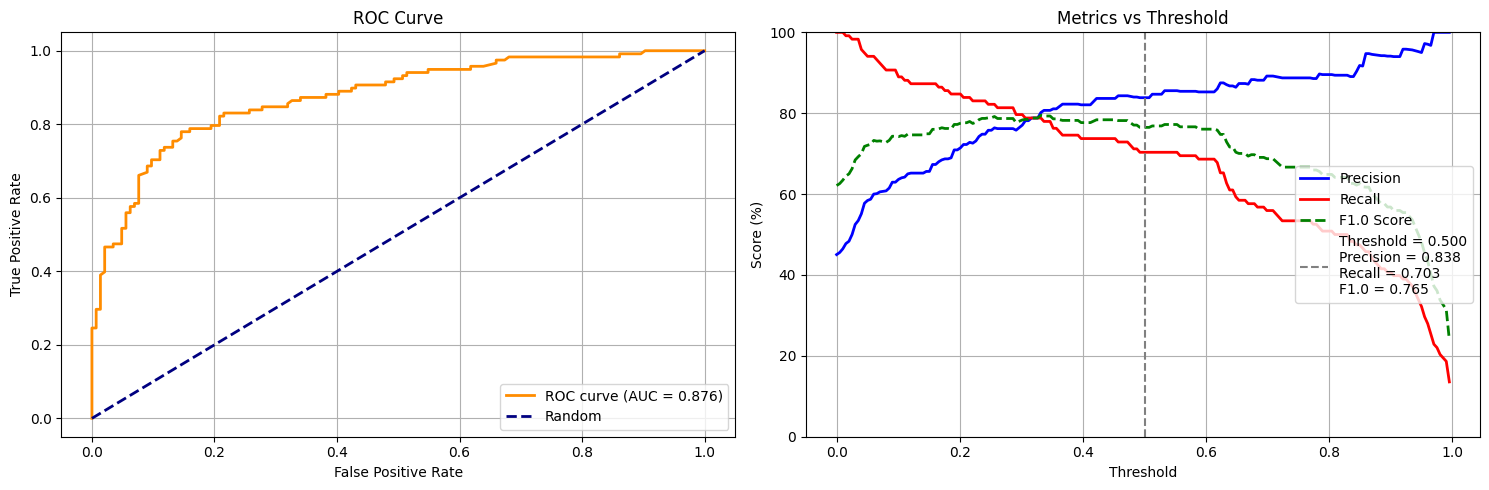

In [4]:
# define pipeline
mlpipeline = ML_PIPELINE(
    model = lgb.LGBMClassifier(verbose=-1),
    preprocessor = PreProcessor()
    )
# fit pipeline
mlpipeline.fit(X_train,y_train)
# make prediction
y_pred = mlpipeline.predict(context = None, model_input = X_test)

# evaluate pipeline with metrics and visualization
results =mlpipeline.evaluate(X_test,y_test, verbose=True, visualize=True)

## Model Explanation

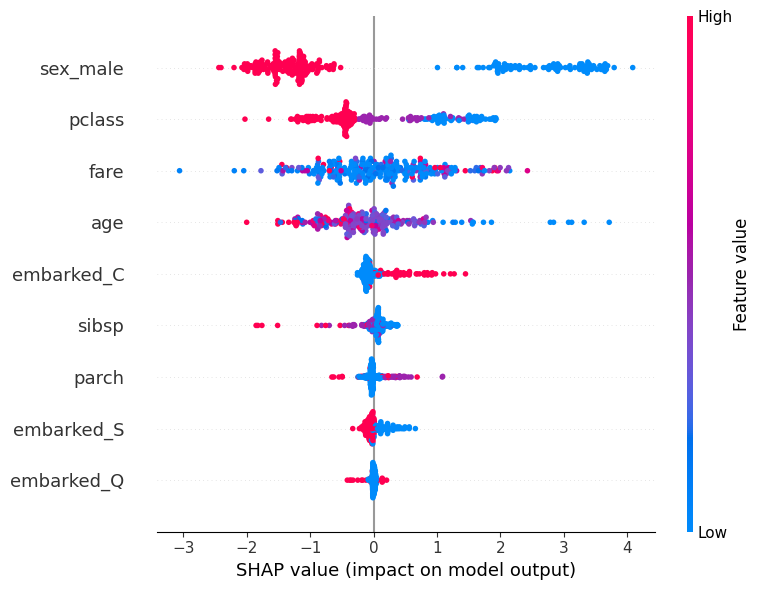

In [5]:
mlpipeline.explain_model(X_test)

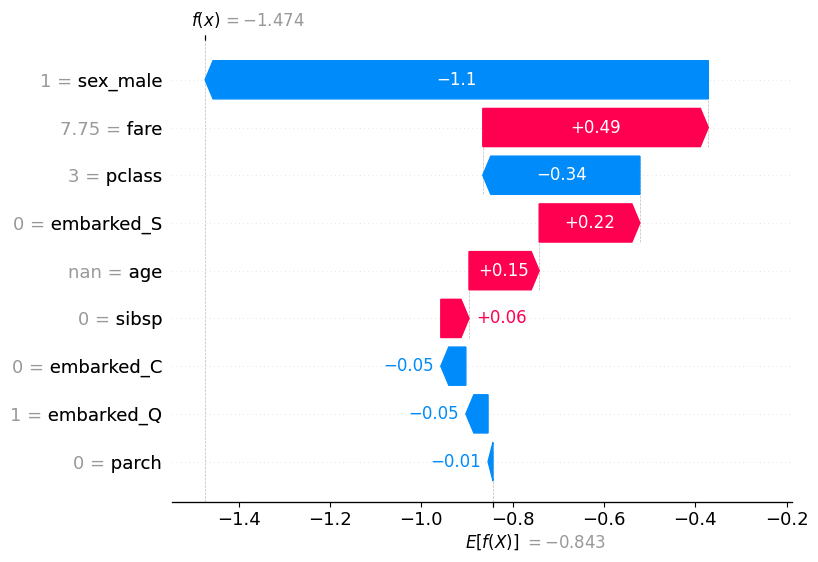

In [6]:
mlpipeline.explain_case(5)


## Swap Algorithm

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.805
F1:        0.767
Precision: 0.832
Recall:    0.712
Pos Rate:  0.385

AUC (threshold independent):
AUC:   0.861


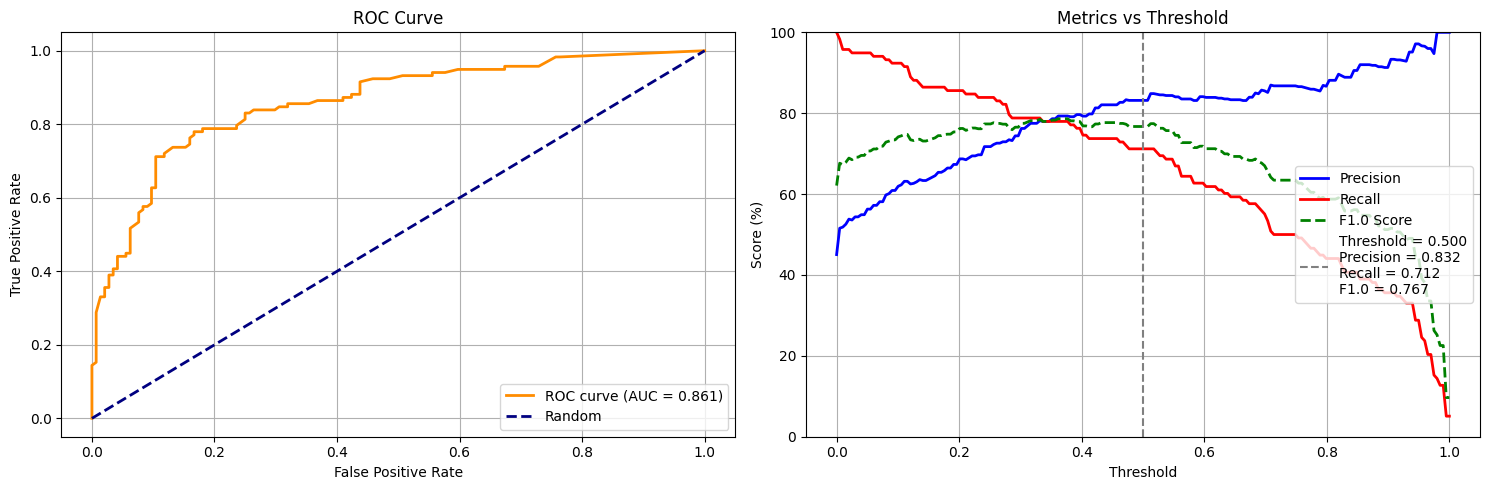

In [7]:
mlpipeline_rf = ML_PIPELINE(
    model = RandomForestClassifier(),
    preprocessor = PreProcessor()
)
mlpipeline_rf.fit(X_train,y_train)
rf_results = mlpipeline_rf.evaluate(X_test,y_test, verbose=True, visualize=True)


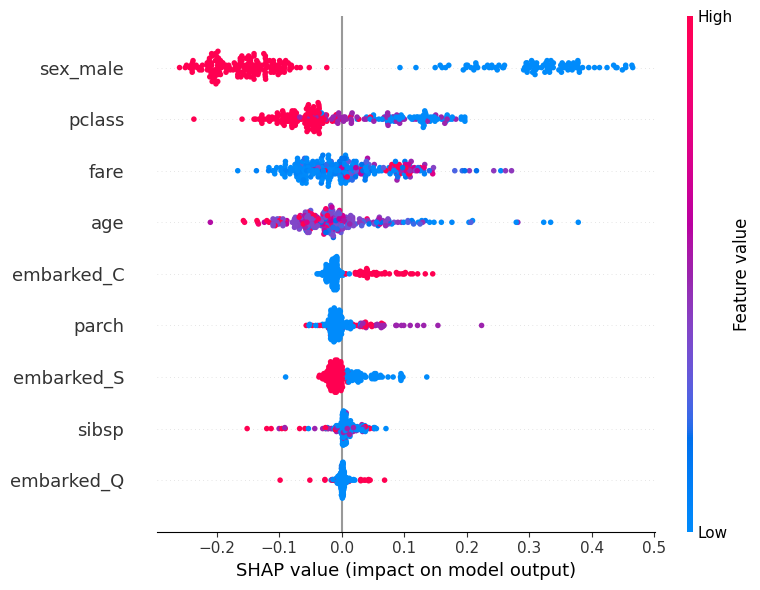

In [8]:
mlpipeline_rf.explain_model(X_test)


# Regression Demo

In [9]:
# Load data
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Fit and Use the Fitted Model

Regression Model Evaluation:
----------------------------------------
RMSE: 0.505
Normalized RMSE: 24.6% of target mean
MAPE: 18.9%
R² Score: 0.805
Adjusted R² Score: 0.805
Improvement over baseline: 55.9%


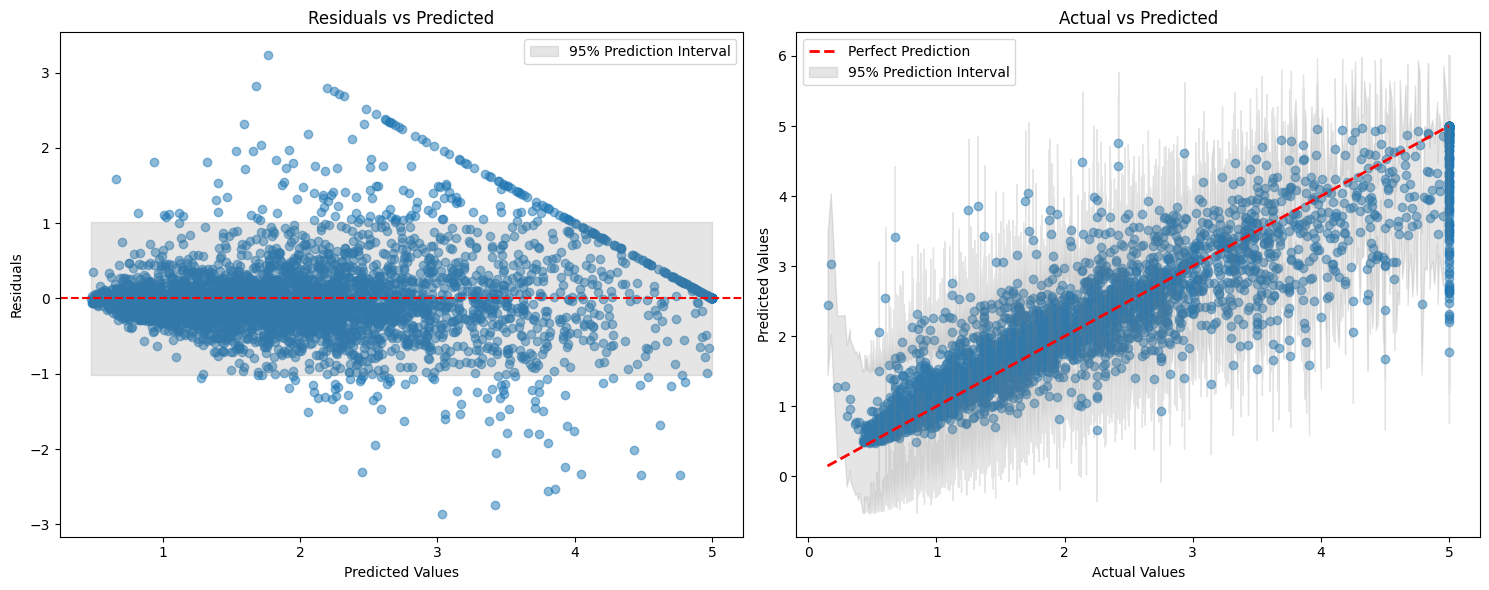

In [10]:
mlpipeline = ML_PIPELINE(
    model = RandomForestRegressor(),
    preprocessor = PreProcessor()
)
mlpipeline.fit(X_train,y_train)
results = mlpipeline.evaluate(X_test,y_test, verbose=True, visualize=True)


## Swap Algorithm

In [11]:
mlpipeline_lgb = ML_PIPELINE(
    model = lgb.LGBMRegressor(),
    preprocessor = PreProcessor()
)
mlpipeline_lgb.fit(X_train,y_train)

Regression Model Evaluation:
----------------------------------------
RMSE: 0.460
Normalized RMSE: 22.4% of target mean
MAPE: 17.7%
R² Score: 0.839
Adjusted R² Score: 0.838
Improvement over baseline: 59.8%


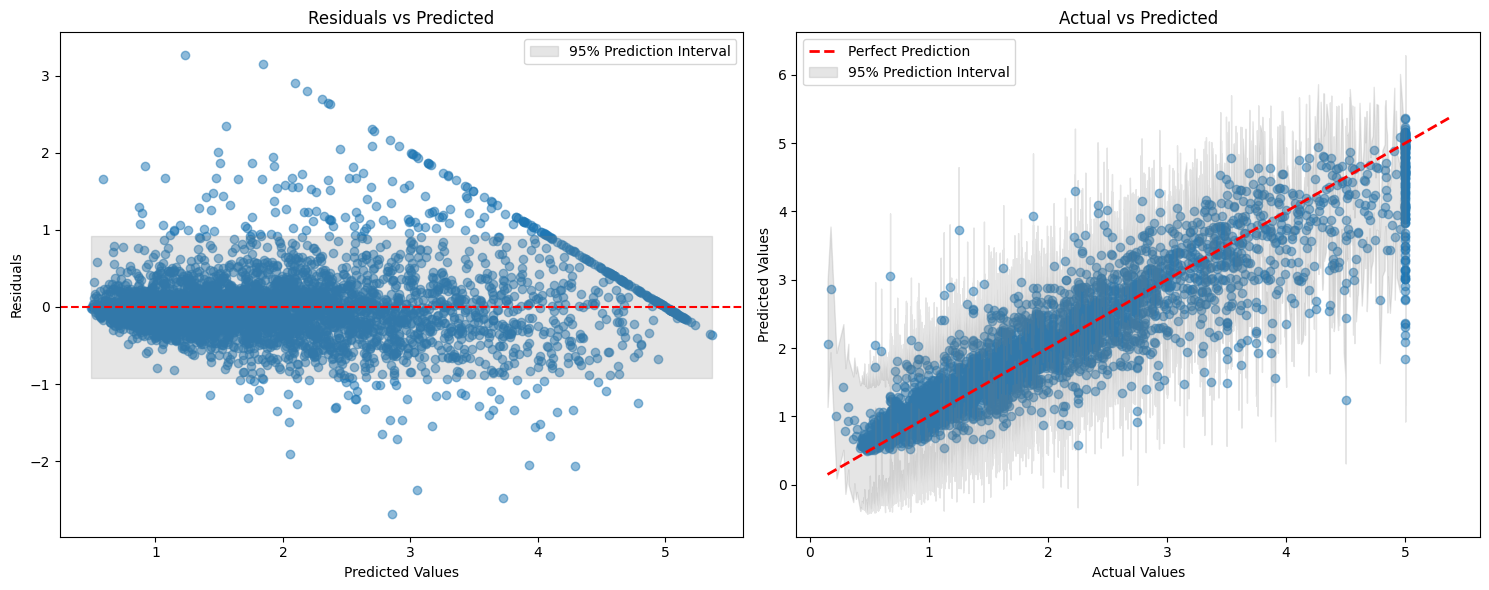

In [12]:
results = mlpipeline_lgb.evaluate(X_test,y_test, verbose=True, visualize=True)

# Log and Use the Logged Model

In [13]:
# log the model
results = mlpipeline_lgb.evaluate(X_test, y_test, verbose=False, visualize=False, log_model=True)
model_info = results['model_info']

2025/04/13 15:47:56 WARNING mlflow.pyfunc: Failed to infer model signature: Type hint <input: <class 'pandas.core.frame.DataFrame'>, output: <class 'numpy.ndarray'>> cannot be used to infer model signature and input example is not provided, model signature cannot be inferred.
2025/04/13 15:48:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Load and Utilize the Logged Model

The loaded model can be used to score new data, and has all the abilities of an ML_PIPELINE instance. For example, it can produce comprehensive reporting and model explanation with a one-liner as demoed below. 

In [14]:
print(model_info.utc_time_created)
print(model_info.run_id)
print(model_info.model_uri)
print(model_info.mlflow_version)

2025-04-13 05:47:56.904848
7797ee13a07e45308d14b298d19f28a5
runs:/7797ee13a07e45308d14b298d19f28a5/ml_pipeline
2.20.3


In [15]:
loaded_model = mlflow.pyfunc.load_model(model_uri=model_info.model_uri) 
loaded_model.predict(pd.DataFrame(X_test))

array([0.58559011, 0.8555311 , 4.70605075, ..., 5.03619613, 0.65563075,
       1.77194961])

Regression Model Evaluation:
----------------------------------------
RMSE: 0.460
Normalized RMSE: 22.4% of target mean
MAPE: 17.7%
R² Score: 0.839
Adjusted R² Score: 0.838
Improvement over baseline: 59.8%


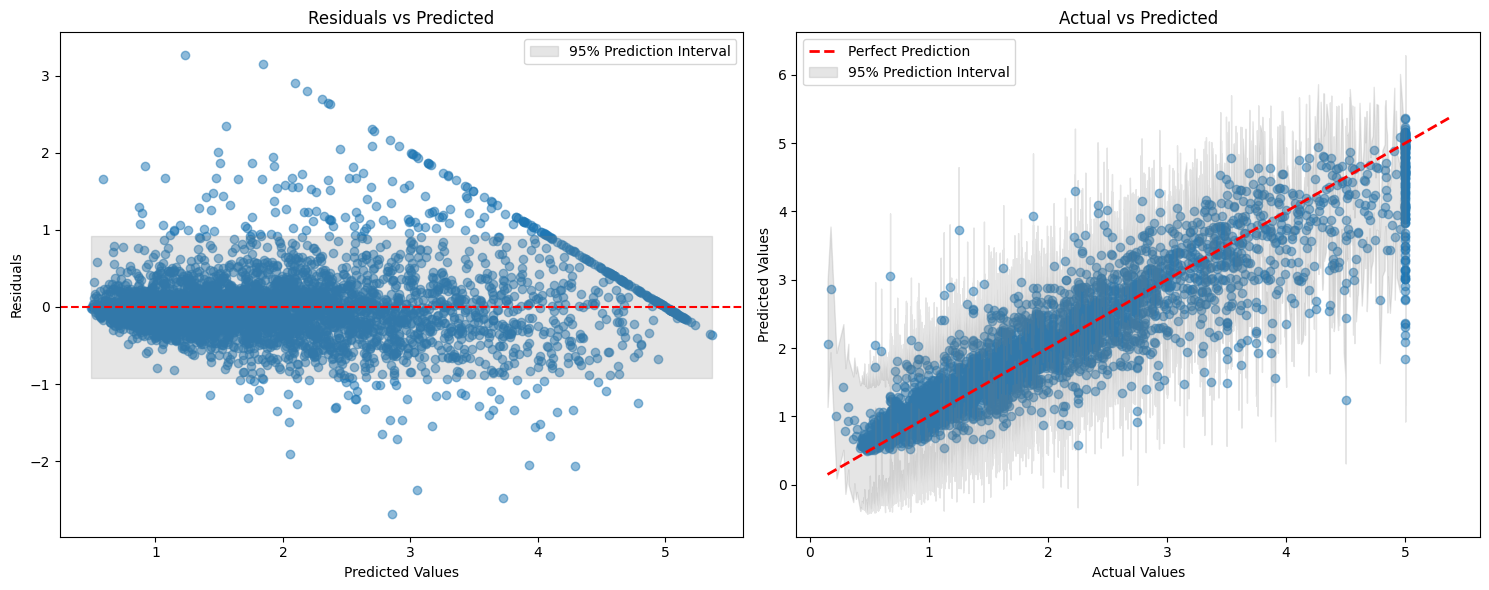

{'rmse': 0.45987687653485965,
 'nrmse': 22.378403100492093,
 'mape': 17.71173699773407,
 'r2': 0.8386101247143777,
 'adj_r2': 0.8382966702345804,
 'rmse_improvement': 59.82664125497816}

In [16]:
unwrapped_model = loaded_model.unwrap_python_model()
unwrapped_model.evaluate(X_test, y_test, verbose=True, visualize=True)

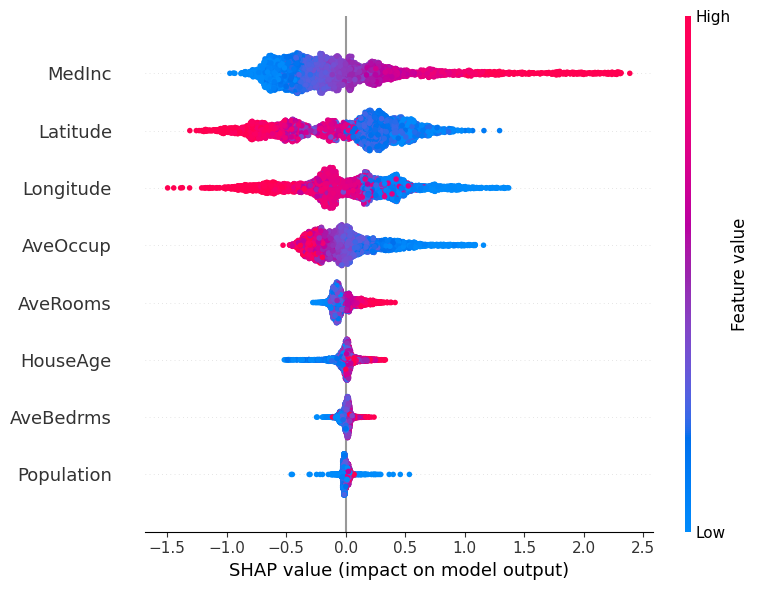

In [17]:
unwrapped_model.explain_model(X_test)

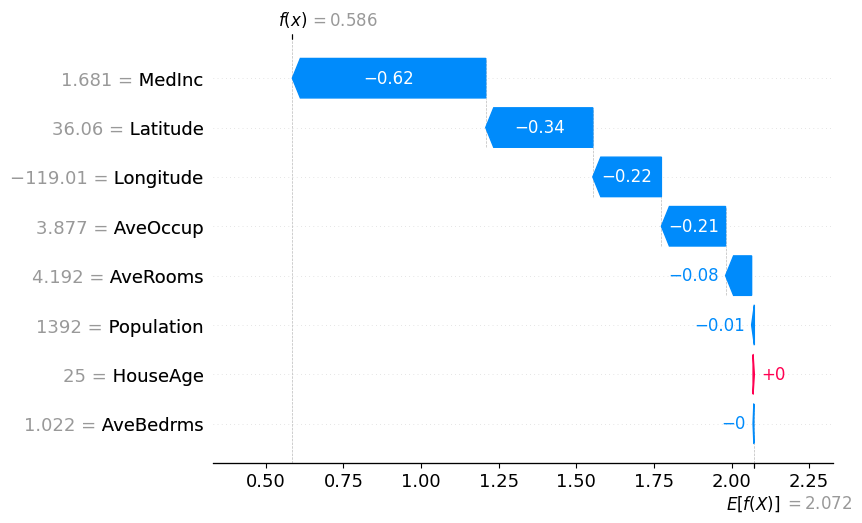

In [18]:
unwrapped_model.explain_case(1)

In [19]:
# call the trained preprocessor as the ml_pipeline attribute
X_test_transformed = unwrapped_model.preprocessor.transform(X_test)
X_train_transformed.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_C,embarked_Q,embarked_S
772,0.840359,-0.956568,-0.495964,-0.442432,-0.495198,1.0,0.0,0.0,1.0
543,-0.355097,0.529551,-0.495964,-0.442432,-0.444889,1.0,0.0,0.0,1.0
289,-1.550554,-0.878352,-0.495964,1.795376,0.890994,0.0,0.0,0.0,1.0
10,-1.550554,1.389936,0.456833,-0.442432,3.747734,1.0,1.0,0.0,0.0
147,-1.550554,-0.096184,-0.495964,-0.442432,0.171375,1.0,0.0,0.0,1.0
